# Step Counting from Accelerometer Signals (UCI HAR Dataset)
This notebook presents a signal-based step counting approach using accelerometer data
from the UCI Human Activity Recognition (HAR) Dataset.

⚠️ Important note:
The UCI HAR Dataset does not provide ground truth step annotations. Therefore, the results
presented here are qualitative and intended for methodological analysis rather than
absolute accuracy evaluation.

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt, find_peaks

#from scipy.interpolate import interp1d

## Dataset

### Dowload and unzip the dataset

After executing the following two cells, the folder will be created:


```
UCI HAR Dataset/
```



In [2]:
# Download the dataset from the website
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI%20HAR%20Dataset.zip

--2026-01-15 10:52:26--  https://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI%20HAR%20Dataset.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘UCI HAR Dataset.zip’

UCI HAR Dataset.zip     [         <=>        ]  58.17M  5.43MB/s    in 2m 44s  

2026-01-15 10:55:12 (363 KB/s) - ‘UCI HAR Dataset.zip’ saved [60999314]



In [3]:
# Unzip the dataset
!unzip -q "UCI HAR Dataset.zip"

### Check structure

If everything has downloaded correctly, you should see the following:



```
activity_labels.txt  features_info.txt	features.txt  README.txt  test	train
```



In [4]:
!ls "UCI HAR Dataset"

activity_labels.txt  features_info.txt	features.txt  README.txt  test	train


### Data Loading

In [5]:
DATA_PATH = "UCI HAR Dataset"

In [6]:
# Load accelerometer windows (train set)
acc_x = np.loadtxt(f"{DATA_PATH}/train/Inertial Signals/body_acc_x_train.txt")
acc_y = np.loadtxt(f"{DATA_PATH}/train/Inertial Signals/body_acc_y_train.txt")
acc_z = np.loadtxt(f"{DATA_PATH}/train/Inertial Signals/body_acc_z_train.txt")

labels = np.loadtxt(f"{DATA_PATH}/train/y_train.txt", dtype=int)
subjects = np.loadtxt(f"{DATA_PATH}/train/subject_train.txt", dtype=int)

In [7]:
# Select subject and activity
SUBJECT_ID = 5
ACTIVITY_ID = 1  # WALKING

mask = (subjects == SUBJECT_ID) & (labels == ACTIVITY_ID)

# Select consecutive windows
body_acc_x_person = acc_x[mask]
body_acc_y_person = acc_y[mask]
body_acc_z_person = acc_z[mask]

# Concatenate windows to form a pseudo-continuous signal
acc_x_concat = body_acc_x_person.reshape(-1)
acc_y_concat = body_acc_y_person.reshape(-1)
acc_z_concat = body_acc_z_person.reshape(-1)

## Raw Accelerometer Signals
The following plots show the raw acceleration signals along the three axes (x, y, z) for a single subject and activity window.

### Display only 3 windows

In [8]:
# Concatenate 3 windows
n_windows3 = 3
acc_x_concat3 = np.concatenate(body_acc_x_person[:n_windows3])
acc_y_concat3 = np.concatenate(body_acc_y_person[:n_windows3])
acc_z_concat3 = np.concatenate(body_acc_z_person[:n_windows3])

# Create an extended timeline
fs = 50 # Sampling frequency (in Hz)
n_samples = 128 # Number of samples per window
window_duration3 = n_samples / fs  # Duration of each window (in seconds)

time_concat3 = np.arange(0, n_windows3 * window_duration3, 1 / 50)

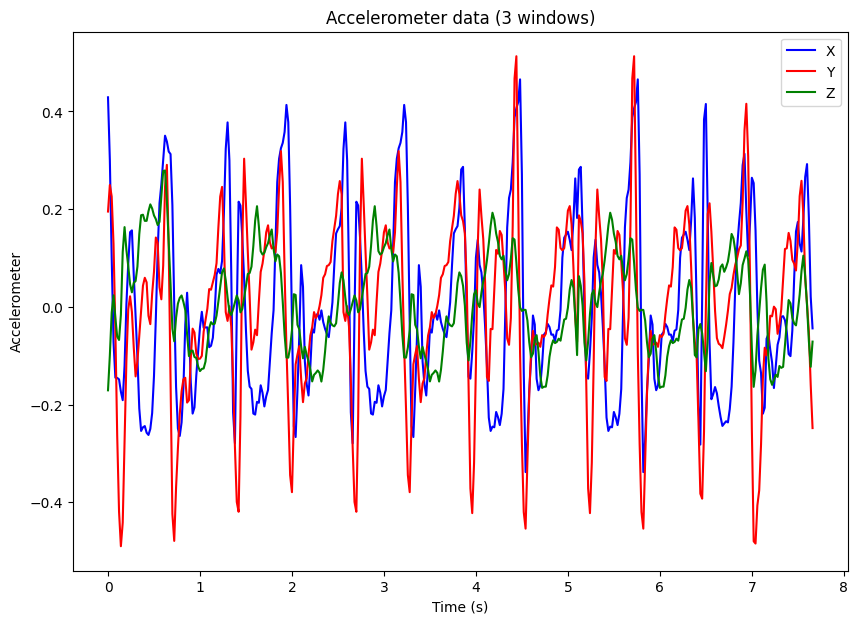

In [9]:
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111)
ax.plot( time_concat3, acc_x_concat3,'b', label='X')
ax.plot( time_concat3, acc_y_concat3, 'r', label='Y')
ax.plot( time_concat3, acc_z_concat3, 'g', label='Z')
ax.set_xlabel('Time (s)')
ax.set_ylabel('Accelerometer')
ax.set_title('Accelerometer data (3 windows)')
ax.legend()
plt.show()

### Display full signal

In [10]:
# Create an extended timeline
fs = 50 # Sampling frequency (in Hz)
time_concat = np.arange(len(acc_x_concat)) / fs

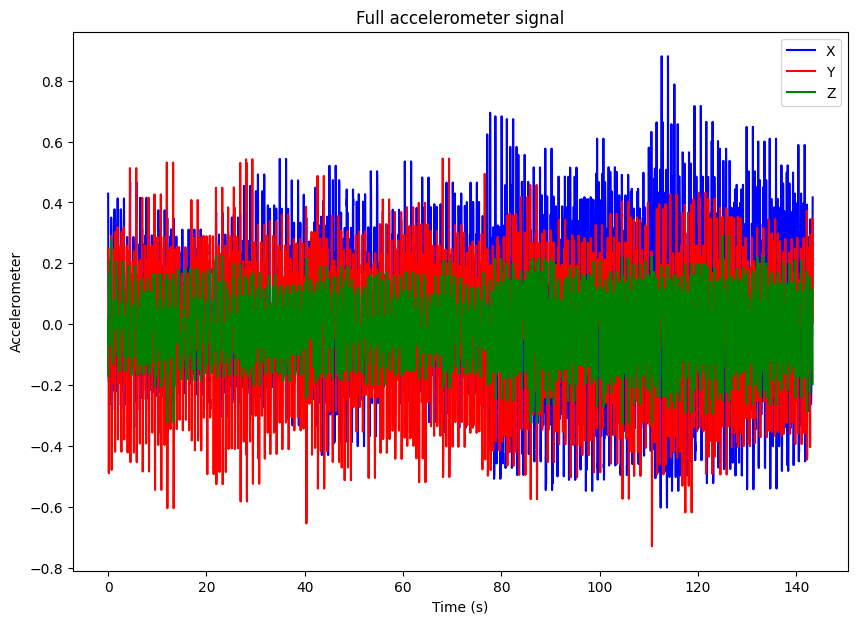

In [11]:
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111)
ax.plot( time_concat, acc_x_concat,'b', label='X')
ax.plot( time_concat, acc_y_concat, 'r', label='Y')
ax.plot( time_concat, acc_z_concat, 'g', label='Z')
ax.set_xlabel('Time (s)')
ax.set_ylabel('Accelerometer')
ax.set_title('Full accelerometer signal')
ax.legend()
plt.show()

## Accelerometer Magnitude

To avoid dependency on smartphone orientation, the acceleration magnitude is computed from the three axes. This is a common approach in step counting literature when device orientation is unknown.

\begin{equation}Magnitude=\sqrt{x^2 + y^2 + z^2}\end{equation}

In [12]:
magnitude = np.sqrt(acc_x_concat**2 + acc_y_concat**2 + acc_z_concat**2)

### Display Magnitude Signal

Displays the signal magnitude of only 3 windows

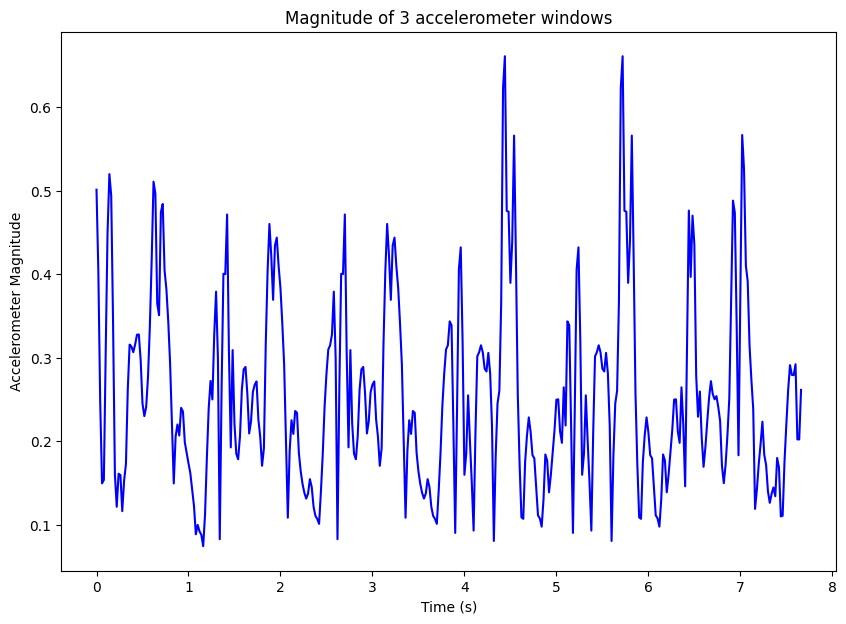

In [13]:
samples3 = len(time_concat3)
magnitude3 = magnitude[:samples3]

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111)
ax.plot(time_concat3, magnitude3,'b')
ax.set_xlabel('Time (s)')
ax.set_ylabel('Accelerometer Magnitude')
ax.set_title('Magnitude of 3 accelerometer windows')
plt.show()

Displays the full magnitude of the accelerometer signal.

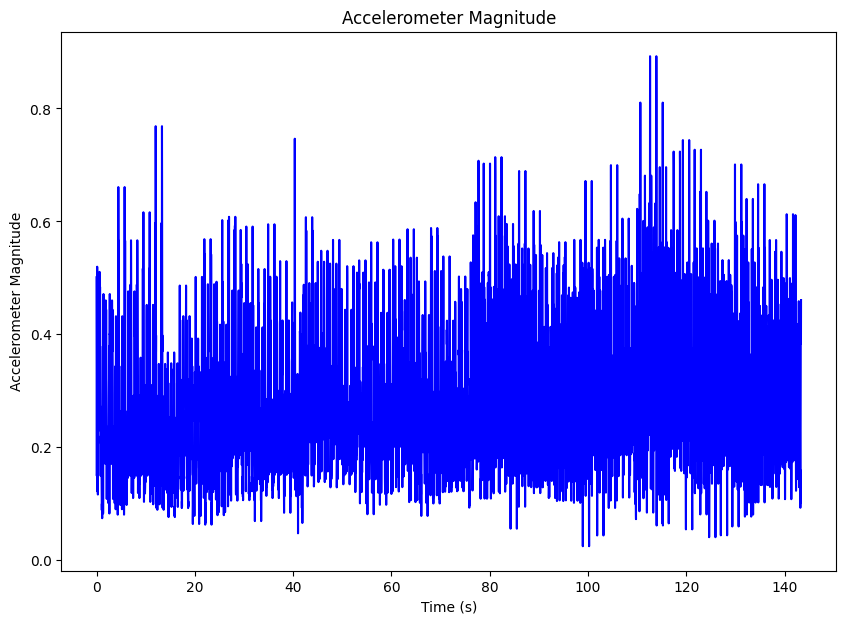

In [14]:
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111)
ax.plot(time_concat, magnitude,'b')
ax.set_xlabel('Time (s)')
ax.set_ylabel('Accelerometer Magnitude')
ax.set_title('Accelerometer Magnitude')
plt.show()

## Signal Centering

The mean value of the acceleration magnitude is removed in order to eliminate the DC
component and center the signal around zero, facilitating peak detection.


In [15]:
magnitude_centered = magnitude - np.mean(magnitude)

### Centred Magnitude Display

Display of the centred magnitude of 3 windows.

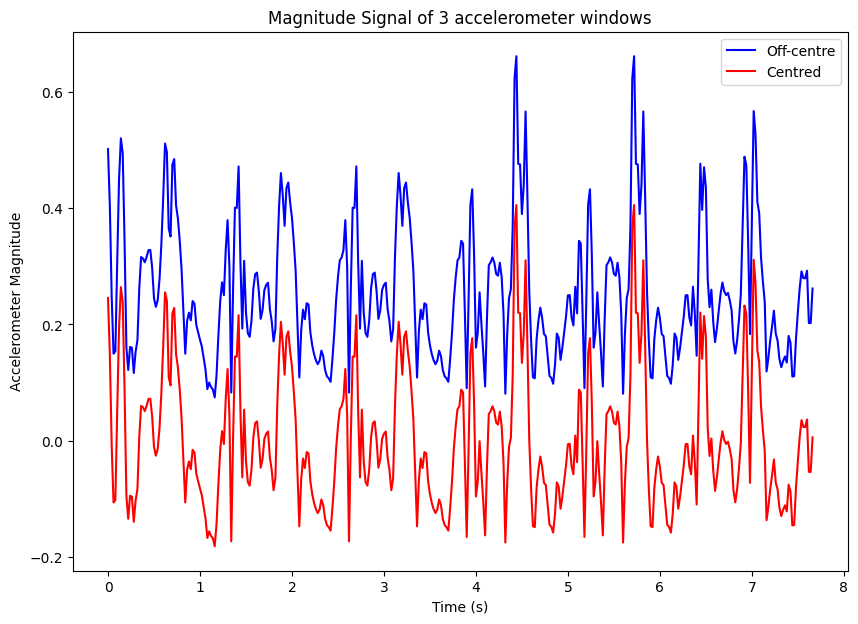

In [16]:
magnitude_centered3 = magnitude3 - np.mean(magnitude3)

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111)
ax.plot(time_concat3, magnitude3,'b', label='Off-centre')
ax.plot(time_concat3, magnitude_centered3, 'r', label='Centred')
ax.set_xlabel('Time (s)')
ax.set_ylabel('Accelerometer Magnitude')
ax.set_title('Magnitude Signal of 3 accelerometer windows')
ax.legend()
plt.show()

Display of the complete centred magnitude.

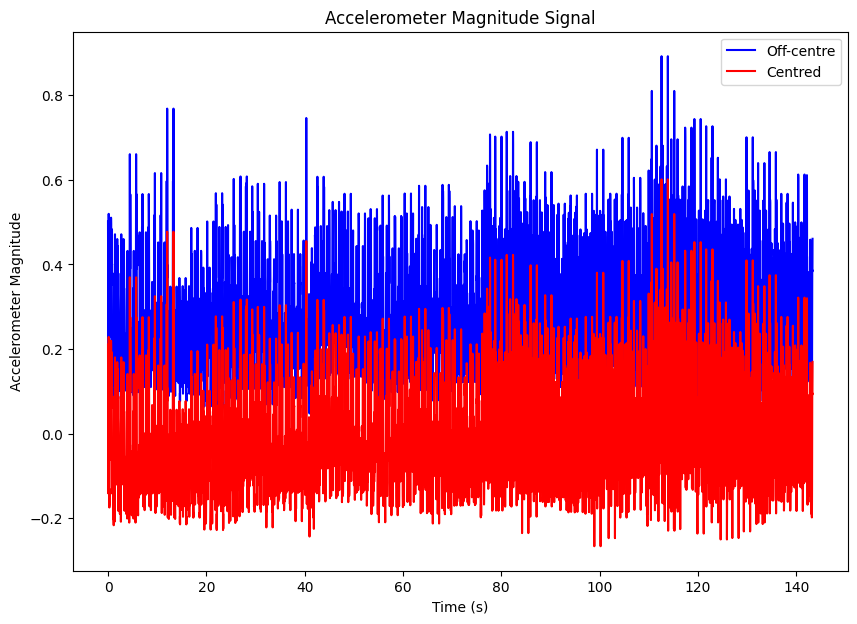

In [17]:
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111)
ax.plot( time_concat, magnitude,'b', label='Off-centre')
ax.plot( time_concat, magnitude_centered, 'r', label='Centred')
ax.set_xlabel('Time (s)')
ax.set_ylabel('Accelerometer Magnitude')
ax.set_title('Accelerometer Magnitude Signal')
ax.legend()
plt.show()

## Band-pass Filtering

Human walking step frequencies typically lie between 1 and 3 Hz. To isolate gait-related
components and suppress low-frequency drift and high-frequency noise, a band-pass filter
is applied to the centered acceleration magnitude.


A fourth-order Butterworth filter was selected as a compromise between frequency
selectivity and signal stability.


In [18]:
def bandpass_filter(signal, fs, lowcut=0.5, highcut=3.0, order=4):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, signal)

In [19]:
fs = 50  # Sampling frequency of UCI HAR
filtered_signal = bandpass_filter(magnitude_centered, fs)

### Filtered signal display

Display of the filtered signal of 3 windows.

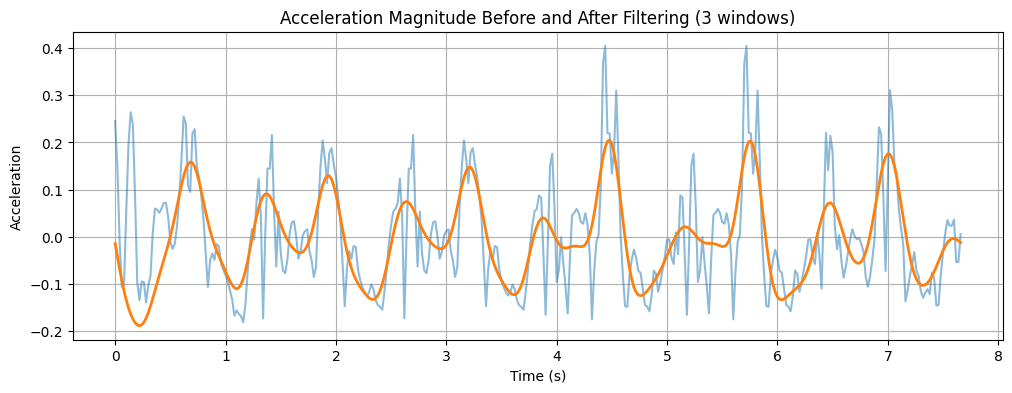

In [20]:
filtered_signal3 = bandpass_filter(magnitude_centered3, fs)

plt.figure(figsize=(12, 4))
plt.plot(time_concat3, magnitude_centered3, label="Centered magnitude", alpha=0.5)
plt.plot(time_concat3, filtered_signal3, label="Band-pass filtered", linewidth=2)
plt.title("Acceleration Magnitude Before and After Filtering (3 windows)")
plt.xlabel("Time (s)")
plt.ylabel("Acceleration")
plt.grid(True)
plt.show()

Display of the complete filtered signal.

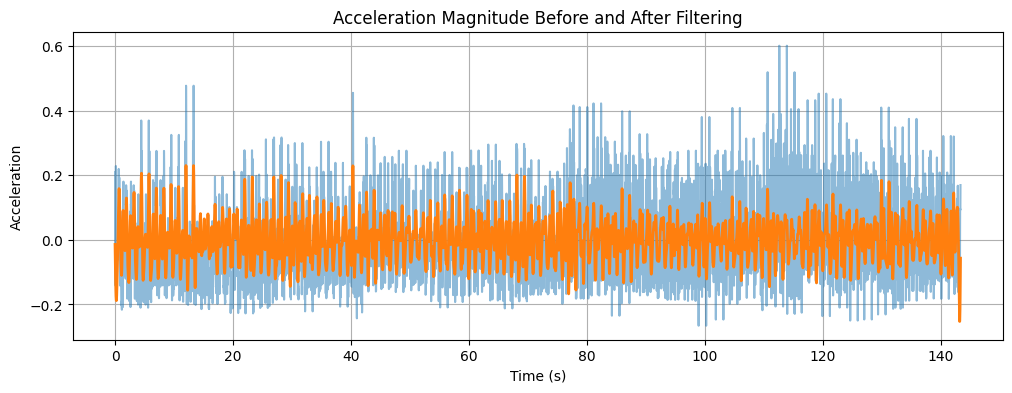

In [21]:
plt.figure(figsize=(12, 4))
plt.plot(time_concat, magnitude_centered, label="Centered magnitude", alpha=0.5)
plt.plot(time_concat, filtered_signal, label="Band-pass filtered", linewidth=2)
plt.title("Acceleration Magnitude Before and After Filtering")
plt.xlabel("Time (s)")
plt.ylabel("Acceleration")
plt.grid(True)
plt.show()

## Step Detection

Steps are identified as local maxima in the filtered acceleration magnitude. An adaptive threshold based on the signal standard deviation is used to ensure robustness across subjects and activities. Additionally, a minimum temporal distance between consecutive peaks is enforced based on physiological constraints of human gait (minimum step  of a human ≈ 0.3–0.4 s).

In [22]:
# Threshold adjusted according to the signal standard deviation
threshold = 0.5 * np.std(filtered_signal)

# Minimum physiological distance between peaks
min_distance = int(0.35 * fs)

# Looking for the peaks
peaks, properties = find_peaks(
    filtered_signal,
    height=threshold,
    distance=min_distance
)

num_steps = len(peaks)

print(f"Number of steps detected: {len(peaks)}")

Number of steps detected: 216


Display of the signal of 3 windows.

Number of steps detected: 10


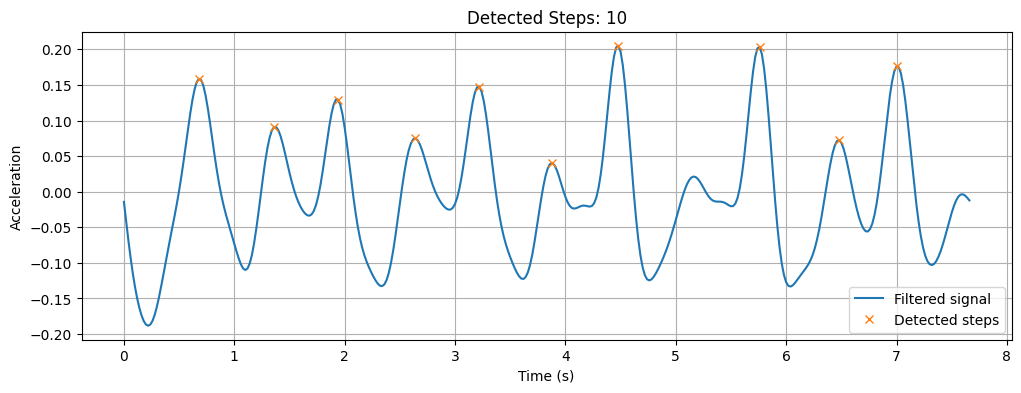

In [23]:
# Look for the peaks in 3 windows
peaks3, properties = find_peaks(
    filtered_signal3,
    height=threshold,
    distance=min_distance
)
num_steps3 = len(peaks3)

print(f"Number of steps detected: {len(peaks3)}")

plt.figure(figsize=(12, 4))
plt.plot(time_concat3, filtered_signal3, label="Filtered signal")
plt.plot(time_concat3[peaks3],  filtered_signal3[peaks3], "x", label="Detected steps")
plt.title(f"Detected Steps: {num_steps3}")
plt.xlabel("Time (s)")
plt.ylabel("Acceleration")
plt.legend()
plt.grid(True)
plt.show()

Display of the complete signal with the detected steps.

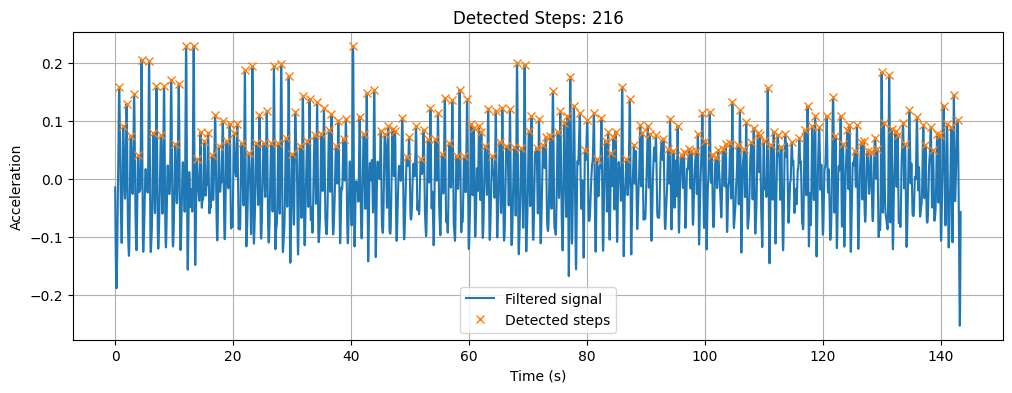

In [24]:
plt.figure(figsize=(12, 4))
plt.plot(time_concat, filtered_signal, label="Filtered signal")
plt.plot(time_concat[peaks],  filtered_signal[peaks], "x", label="Detected steps")
plt.title(f"Detected Steps: {num_steps}")
plt.xlabel("Time (s)")
plt.ylabel("Acceleration")
plt.legend()
plt.grid(True)
plt.show()